In [13]:
class North:
    def turnLeft(self):
        return West

    def turnRight(self):
        return East

class South:
    def turnLeft(self):
        return East

    def turnRight(self):
        return West

class East:
    def turnLeft(self):
        return North

    def turnRight(self):
        return South

class West:
    def turnLeft(self):
        return South

    def turnRight(self):
        return North

In [14]:

from copy import deepcopy
import random
from enum import Enum

class Action(Enum):
    Forward = "Forward"
    TurnLeft = "TurnLeft"
    TurnRight = "TurnRight"
    Shoot = "Shoot"
    Grab = "Grab"
    Climb = "Climb"


class Coords:
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def adjacentCells(self, gridWidth, gridHeight):
        toLeft = Coords(self._x - 1, self._y ) if (self._x > 0) else False
        toRight =  Coords(self._x + 1, self._y ) if (self._x < gridWidth - 1) else False
        below = Coords(self._x, self._y  - 1) if (self._y  > 0) else False
        above = Coords(self._x, self._y  + 1) if (self._y  < gridHeight - 1) else False

        return [toLeft, toRight, below, above]
    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y


class Percept:
    def __init__(self, stench, breeze, glitter, bump, scream, isTerminated, reward):
        self.stench = stench
        self.breeze = breeze
        self.glitter = glitter
        self.bump = bump
        self.scream = scream
        self.isTerminated = isTerminated
        self.reward = reward

    def show(self):
        return "stench:%s breeze:%s glitter:%s bump:%s scream:%s isTerminated:%s reward:%s" % (self.stench, self.breeze, self.glitter, self.bump, self.scream, self.isTerminated, self.reward)


class Environment:
    def __init__(self,
                 gridWidth,
                 gridHeight,
                 pitProb,
                 allowClimbWithoutGold,
                 agent,
                 pitLocations,
                 isTerminated,
                 wumpusLocation,
                 wumpusAlive,
                 goldLocation):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.pitProb = pitProb
        self.allowClimbWithoutGold = allowClimbWithoutGold
        self.agent = agent
        self.pitLocations = pitLocations
        self.isTerminated = isTerminated
        self.wumpusLocation = wumpusLocation
        self.wumpusAlive = wumpusAlive
        self.goldLocation = goldLocation

    def isPitAt(self, coords):
        for item in self.pitLocations:
            if(item.x == coords.x and item.y == coords.y):
                return True

        return False

    def isWumpusAt(self, coords):
        if(self.wumpusLocation is None):
            return False
        elif(self.wumpusLocation.x == coords.x and self.wumpusLocation.y == coords.y):
            return True
        else:
            return False

    def isAgentAt(self, coords):
        if(self.agent.location.x == coords.x and self.agent.location.y == coords.y):
            return True
        else:
            return False

    def isGlitter(self):
        if(self.goldLocation is None):
            return False
        elif(self.agent.location.x == self.goldLocation.x and self.agent.location.y == self.goldLocation.y):
            return True
        else:
            return False           

    def isGoldAt(self, coords):
        if(self.goldLocation is None):
            return False
        elif(coords.x == self.goldLocation.x and coords.y == self.goldLocation.y):
            return True
        else:
            return False         

    def killAttemptSuccessful(self):
        if(self.wumpusLocation is None):
            return True

        wumpusInLineOfFire = False
        
        if self.agent.orientation == West:
            if (self.agent.location.x > self.wumpusLocation.x and self.agent.location.y == self.wumpusLocation.y):
                wumpusInLineOfFire = True
        elif self.agent.orientation == East:
            if (self.agent.location.x < self.wumpusLocation.x and self.agent.location.y == self.wumpusLocation.y):
                wumpusInLineOfFire = True
        elif self.agent.orientation == South:
            if (self.agent.location.x == self.wumpusLocation.x and self.agent.location.y > self.wumpusLocation.y):
                wumpusInLineOfFire = True
        elif self.agent.orientation == North:
            if (self.agent.location.x == self.wumpusLocation.x and self.agent.location.y < self.wumpusLocation.y):
                wumpusInLineOfFire = True
        
        return self.agent.hasArrow and self.wumpusAlive and wumpusInLineOfFire

    def adjacentCells(self, coords):
        toLeft = Coords(coords.x - 1, coords.y) if (coords.x > 0) else False
        toRight =  Coords(coords.x + 1, coords.y) if (coords.x < self.gridWidth - 1) else False
        below = Coords(coords.x, coords.y - 1) if (coords.y > 0) else False
        above = Coords(coords.x, coords.y + 1) if (coords.y < self.gridHeight - 1) else False

        return [toLeft, toRight, below, above]

    def isPitAdjacent(self, coords):
        adjacent = self.adjacentCells(coords)
        for item in adjacent:
            if(item != False):
                if(self.isPitAt(item)):
                    return True
                    
        return False

    def isWumpusAdjacent(self, coords):
        adjacent = self.adjacentCells(coords)

        for item in adjacent:
            if(item != False):
                if(self.isWumpusAt(item)):
                    return True

        return False

    def isBreeze(self):
        return self.isPitAdjacent(self.agent.location)

    def isStench(self):
        return self.isWumpusAdjacent(self.agent.location) or self.isWumpusAt(self.agent.location)

    def applyAction(self, action):
        if (self.isTerminated):
            return self, Percept(False, False, False, False, False, True, 0)
        else:
            if action.name is Action.Forward.name:                
                movedAgent = self.agent.forward(
                    self.gridWidth, self.gridHeight)

                death = (self.isWumpusAt(movedAgent.location)
                         and self.wumpusAlive) or self.isPitAt(movedAgent.location)
                
                newAgent = deepcopy(movedAgent)
                newAgent.isAlive = False if death else True

                Bump = False
                if(newAgent.location.x == self.agent.location.x and newAgent.location.y == self.agent.location.y):
                    Bump = True
                
                newEnv = Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, newAgent, self.pitLocations,
                                     death, self.wumpusLocation, self.wumpusAlive, newAgent.location if self.agent.hasGold else self.goldLocation)
                return newEnv, Percept(newEnv.isStench(), newEnv.isBreeze(), newEnv.isGlitter(), Bump, False, False if newAgent.isAlive else True,  -1 if newAgent.isAlive else -1001)
            elif action.name is Action.TurnLeft.name:
                return Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, self.agent.turnLeft(), self.pitLocations, self.isTerminated,  self.wumpusLocation,  self.wumpusAlive,  self.goldLocation), Percept(self.isStench(), self.isBreeze(), self.isGlitter(), False, False,  False, -1)
            elif action.name is Action.TurnRight.name:
                return Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, self.agent.turnRight(), self.pitLocations, self.isTerminated, self.wumpusLocation, self.wumpusAlive, self.goldLocation), Percept(self.isStench(), self.isBreeze(), self.isGlitter(), False, False,  False, -1)
            elif action.name is Action.Grab.name:
                newAgent = deepcopy(self.agent)
                newAgent.hasGold = self.isGlitter()

                return Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, newAgent, self. pitLocations, self.isTerminated, self.wumpusLocation, self.wumpusAlive, self.agent.location if newAgent.hasGold else self.goldLocation), Percept(self.isStench(), self.isBreeze(), self.isGlitter(), False, False,  False, -1)
            elif action.name is Action.Climb.name:
                inStartLocation = False
                if(self.agent.location.x == Coords(0, 0).x and self.agent.location.y == Coords(0, 0).y):
                    inStartLocation = True

                success = self.agent.hasGold and inStartLocation
                isTerminated = success or self.allowClimbWithoutGold

                return Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, self.agent, self.pitLocations, isTerminated, self.wumpusLocation, self.wumpusAlive, self.goldLocation), Percept(False, False, self.agent.hasGold, False, False, isTerminated, 999 if success else -1)
            elif action.name is Action.Shoot.name:
                hadArrow = self.agent.hasArrow
                wumpusKilled = self.killAttemptSuccessful()
                newAgent = deepcopy(self.agent)
                newAgent.hasArrow = False
                return Environment(self.gridWidth, self.gridHeight, self.pitProb, self.allowClimbWithoutGold, newAgent, self.pitLocations, self.isTerminated, self.wumpusLocation, self.wumpusAlive and not wumpusKilled, self.goldLocation), Percept(self.isStench(), self.isBreeze(), self.isGlitter(), False, wumpusKilled, False, -11 if hadArrow else -1)

    def visualize(self):
        wumpusSymbol =  "W" if (self.wumpusAlive == True) else "w"         

        Rows = []
        for y in range(self.gridHeight):
            Cells = []
            for x in range(self.gridWidth):
                A = "A" if (self.isAgentAt(Coords(x, y))) else " "
                P = "P" if (self.isPitAt(Coords(x, y))) else " "
                G = "G" if (self.isGoldAt(Coords(x, y))) else " "
                W = wumpusSymbol if (self.isWumpusAt(Coords(x, y))) else " "
                
                Cells.append("%s%s%s%s" % (A, P, G, W))

            Rows.append('|'.join(Cells))

        return '\n'.join(Rows)

class WumpusWorldEnvironment:
    def apply(self, gridWidth, gridHeight, pitProb, allowClimbWithoutGold):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.pitProb = pitProb
        self.allowClimbWithoutGold = allowClimbWithoutGold

        cellIndexes = []
        pitLocations = []

        for x in range(gridWidth):
            for y in range(gridHeight):
                cellIndexes.append(Coords(x, y))

        cellIndexes.pop(0)
        pitCount = 0
        for item in cellIndexes:
            if random.uniform(0, 1) < pitProb:
                if(pitCount == 3):
                    break
                pitLocations.append(item)
                pitCount = pitCount + 1

        env = Environment(
            gridWidth,
            gridHeight,
            pitProb,
            allowClimbWithoutGold,
            Agent(),
            pitLocations,
            False,
            self.randomLocationExceptOrigin(),
            True,
            self.randomLocationExceptOrigin()
        )

        return env, Percept(env.isStench(), env.isBreeze(), False, False, False, False,  0.0)

    def randomLocationExceptOrigin(self):
        x = random.randrange(self.gridWidth)
        y = random.randrange(self.gridHeight)

        if x == 0 and y == 0:
            self.randomLocationExceptOrigin()
        else:
            return Coords(x, y)


In [15]:
from copy import deepcopy

class Agent:
    def __init__(self, location = Coords(0,0), orientation = East, hasGold = False, hasArrow = True, isAlive = True):
        self.location =  location
        self.orientation = orientation
        self.hasGold = hasGold
        self.hasArrow = hasArrow
        self.isAlive = isAlive

    def turnLeft(self):
        ret = deepcopy(self)
        ret.orientation = self.orientation.turnLeft(self)

        return ret

    def turnRight(self):
        ret = deepcopy(self)
        ret.orientation  = self.orientation.turnRight(self)

        return ret

    def useArrow(self):
        ret = deepcopy(self)
        ret.hasArrow = False
    
        return ret

    def forward(self, gridWidth, gridHeight):
        ret = deepcopy(self)
        
        newAgentLocation = False

        if self.orientation == West:
            newAgentLocation = Coords(max(0, self.location.x - 1), self.location.y)
        elif self.orientation == East:
            newAgentLocation = Coords(min(gridWidth - 1, self.location.x + 1), self.location.y)
        elif self.orientation == South:
            newAgentLocation = Coords(self.location.x, max(0, self.location.y - 1))
        elif self.orientation == North:
            newAgentLocation = Coords(self.location.x, min(gridHeight - 1, self.location.y + 1))


        ret.location = newAgentLocation
        
        return ret

    def applyMoveAction(self, action, gridWidth, gridHeight):
        if action == Action.Forward:
            return self.forward(gridWidth, gridHeight)
        elif action == Action.TurnRight:
            return self.turnRight()
        elif action == Action.TurnLeft:
            return self.turnLeft()


In [16]:
from copy import deepcopy
from random import randrange
import sys
import numpy as np
sys.path.append(".")


class DeepQAgent():
    def __init__(self, gridHeight=4, gridWidth=4, agentState=Agent, safeLocations=[Coords(0,0)], stenchLocations=[], breezeLocations=[], agentLocationGrid = [], safeLocationGrid = [], stenchLocationGrid = [], breezeLocationGrid = [], agentHasGold = False, agentSensesGold = False, agentHasArrow = False, agentHeardScream = False, agentOrientationSet= False):
        self.gridHeight = gridHeight
        self.gridWidth = gridWidth
        self.agentState = agentState()
        self.safeLocations = safeLocations
        self.stenchLocations = stenchLocations
        self.breezeLocations = breezeLocations
        self.agentLocationGrid = agentLocationGrid
        self.safeLocationGrid = safeLocationGrid
        self.stenchLocationGrid = stenchLocationGrid
        self.breezeLocationGrid = breezeLocationGrid
        self.agentHasGold = agentHasGold
        self.agentSensesGold = agentSensesGold
        self.agentHasArrow = agentHasArrow
        self.agentHeardScream = agentHeardScream
        self.agentOrientationSet = agentOrientationSet

    #Helper method to print grids nicely
    def printTable(self, grid):
        rows = []
        for i in range(self.gridHeight):
            cells = []
            for j in range(self.gridWidth):            
                cells.append("%s" % (grid[i][j]))

            rows.append('|'.join(cells))
        return '\n'.join(rows)

    #Helper method to print all the different belief state values
    def printBeliefState(self, percept):
        print("-- Percept --")
        print(percept.show())

        print('-- Current Agent Location --')
        print(self.printTable(self.agentLocationGrid))

        print('-- Agent Orientation Set --')
        print(self.agentOrientationSet)        

        print('-- Safe Locations --')
        print(self.printTable(self.safeLocationGrid))

        print('-- Stench Locations --')
        print(self.printTable(self.stenchLocationGrid))

        print('-- Breeze Locations --')
        print(self.printTable(self.breezeLocationGrid))    

        print('-- Agent Has Gold --')
        print(self.agentHasGold)  

        print('-- Agent Senses Gold --')
        print(self.agentSensesGold)  

        print('-- Agent Has Arrow --')
        print(self.agentHasArrow)  

        print('-- Agent Heard Scream --')
        print(self.agentHeardScream)          

    #flattening and concatenating all the arrays to one array of length 72
    def getAgentBeliefState(self):               
        return np.concatenate((np.array(self.agentLocationGrid).flatten(), np.array(self.safeLocationGrid).flatten(),np.array(self.stenchLocationGrid).flatten(), np.array(self.breezeLocationGrid).flatten(), np.array(self.agentOrientationSet).flatten(), np.array(self.agentHasGold).flatten(), np.array(self.agentSensesGold).flatten(), np.array(self.agentHasArrow).flatten(), np.array(self.agentHeardScream).flatten()))

    #Set is represented as a list of 1s and 0s
    #I don't think the order matters, but we'll say:
    #  [1, 0, 0, 0] = North
    #  [0, 1, 0, 0] = South
    #  [0, 0, 1, 0] = East
    #  [0, 0, 0, 1] = West
    def buildAgentOrientatioSet(self, orientation):
        orientationSet = []

        if orientation == North:
            orientationSet.append([1, 0, 0, 0])
        elif orientation == South:
            orientationSet.append([0, 1, 0, 0])
        elif orientation == East:
            orientationSet.append([0, 0, 1, 0])
        elif orientation == West:
            orientationSet.append([0, 0, 0, 1])

        return orientationSet

    #Build agent location grid
    def buildAgentLocationGrid(self, coords):
        rows = []

        for i in range(self.gridHeight):
            cols = []
            for j in range(self.gridWidth):
                if(i == coords.y and j == coords.x):
                    cols.append(1)
                else:
                    cols.append(0)   

            rows.append(cols)

        return rows
    
    #Build safe location grid
    def buildSafeLocationGrid(self, visited):
        rows = []

        for i in range(self.gridHeight):
            cols = []
            for j in range(self.gridWidth):
                if any(d.y == i and d.x == j for d in visited):
                    cols.append(1)
                else:
                    cols.append(0)   

            rows.append(cols)

        return rows            

    #Build stench location grid
    def buildStenchLocationGrid(self, stenches):
        rows = []

        for i in range(self.gridHeight):
            cols = []
            for j in range(self.gridWidth):
                if any(d.y == i and d.x == j for d in stenches):
                    cols.append(1)
                else:
                    cols.append(0)   

            rows.append(cols)

        return rows 
    
    #Build breeze location grid
    def buildBreezeLocationGrid(self, breezes):
        rows = []

        for i in range(self.gridHeight):
            cols = []
            for j in range(self.gridWidth):
                if any(d.y == i and d.x == j for d in breezes):
                    cols.append(1)
                else:
                    cols.append(0)   

            rows.append(cols)

        return rows

    #apply next action. Action value is passed in from training(0,1,2,4,5)
    def nextAction(self, percept, action):
        ret = deepcopy(self)

        if(percept.stench == True):
            ret.stenchLocations.append(ret.agentState.location)
        if(percept.breeze == True):
            ret.breezeLocations.append(ret.agentState.location) 

        ret.agentLocationGrid = self.buildAgentLocationGrid(ret.agentState.location)
        ret.safeLocationGrid = self.buildSafeLocationGrid(ret.safeLocations)  
        ret.stenchLocationGrid = self.buildStenchLocationGrid(ret.stenchLocations)       
        ret.breezeLocationGrid = self.buildBreezeLocationGrid(ret.breezeLocations)
        ret.agentHasGold =  1 if ret.agentState.hasGold == True else 0
        ret.agentSensesGold = 1 if percept.glitter == True else 0
        ret.agentHasArrow = 1 if ret.agentState.hasArrow == True else 0
        ret.agentHeardScream = 1 if percept.scream == True else 0
        ret.agentOrientationSet = self.buildAgentOrientatioSet(ret.agentState.orientation)

        if action == 0:
            ret.agentState = ret.agentState.forward(
                self.gridWidth, self.gridHeight)
            ret.safeLocations.append(ret.agentState.location)

            return ret, Action.Forward
        elif action == 1:
            ret.agentState = ret.agentState.turnLeft()
            return ret, Action.TurnLeft
        elif action == 2:
            ret.agentState = ret.agentState.turnRight()
            return ret, Action.TurnRight
        elif action == 3:
            ret.agentState = ret.agentState.useArrow()
            return ret, Action.Shoot
        if action == 4:
            if percept.glitter == True:
                ret.agentState.hasGold = True

            return ret, Action.Grab
        if action == 5:
            ret.agentState.isTerminated = True
            return ret, Action.Climb                            

In [17]:
import torch
import pycuda.driver as cuda
# cuda.init()
# print(f"is cuda available?: {torch.cuda.is_available()}")
# print(f"What is the current device?: {torch.cuda.current_device()}")
# print(f"Name of device: {cuda.Device(torch.cuda.current_device()).name()}")
# device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [18]:
import os
model_path = os.path.join(os.getcwd(), 'model')
os.makedirs(model_path, exist_ok=True)
print(model_path)
model_filename = 'deepQ_wumpus_model_2.pt'
model_file_path = os.path.join(model_path, model_filename)

/home/karanteckwani/Projects/wumpus-world/wumpusWorld/model


In [19]:
import time
import sys
import copy
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
from collections import deque
from random import randrange

sys.path.append(".")

l1 = 72 # number of features as defined by question 1. Returned from getAgentBeliefState()
l2 = 512
l3 = 128
l4 = 6 # number of actions available -- all randomized within DeepQAgent Class
start_time = time.time()
gamma = 0.85
epsilon = 0.3
epochs = 10000
losses = []
max_moves = 250
mem_size = 1000
batch_size = 128
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
replay = deque(maxlen=mem_size)
sync_freq = 500
j=0
won_counter = 0

def get_model(path):
    if not os.path.isfile(path):
        print('new model setup from scratch')
        model = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l3),
            torch.nn.ReLU(),
            torch.nn.Linear(l3,l4)
        )
    else:
        print('Model loaded from filepath')
        model = torch.load(path)
    model2 = copy.deepcopy(model)
    model2.load_state_dict(model.state_dict())

    return model, model2

def run(env, agent, percept, action):
    agent, action = agent.nextAction(percept, action)
    env, percept = env.applyAction(action)

    return env, agent, percept

def getState(belief_state):
    state_ = np.array([belief_state]).reshape(1,l1) + np.random.rand(1,l1)/100.0   
    state = torch.from_numpy(state_).float()

    return state_, state

model, model2 = get_model(model_file_path)
# model.to(device)
# model2.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
    current = i
    terminated = False
    reward = 0
    status = 1
    mov = 0
    world = WumpusWorldEnvironment()
    initialEnv, initialPercept = world.apply(4, 4, 0.2, False)        
    agent = DeepQAgent(4, 4)    
    randGen = randrange(6)
    env, agent, percept = run(initialEnv, agent, initialPercept, randGen)
    #method to return all belief state variables found in question 1 of the assignment description
    belief_state = agent.getAgentBeliefState()
    state1_, state1 = getState(belief_state)

    while terminated == False:
        j+=1
        mov += 1      
#         state1 = state1.to(device)
        qval = model(state1)
#         qval = qval.to('cpu')
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)

        nextMove = action_.item()
        if (random.random() < epsilon):
            nextMove = np.random.randint(0,6)
        else:
            nextMove = np.argmax(qval_)

        env, agent, percept = run(env, agent, percept, nextMove) 
 
        #method to return all belief state variables found in question 1 of the assignment description
        belief_state = agent.getAgentBeliefState()
        state2_, state2 = getState(belief_state)
        reward += percept.reward

        exp =  (state1, action_, reward, state2, percept.isTerminated)
        replay.append(exp)
        state1 = state2     

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size) 
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
#             state1_batch = state1_batch.to(device)
            Q1 = model(state1_batch) 
#             Q1 = Q1.to('cpu')
            
            with torch.no_grad():
#                 state2_batch = state2_batch.to(device)
                Q2 = model2(state2_batch)
#                 Q2 = Q2.to('cpu')
                
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item()) 
            print(env.visualize())
            if i != epochs:
                clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: 
                model2.load_state_dict(model.state_dict())  
            
            if i % 200 == 0:
                torch.save(model, model_file_path)
            
            if reward > 0:
                won_counter += 1
                print(f"Win rate: {won_counter/epochs*100}%")

        if mov > max_moves:
            terminated = True

        if percept.isTerminated == True:
            terminated = True

losses = np.array(losses)            


9999 1495.604736328125
    |   W|    |    
AP  |    |    |    
 P  |    |    |    
 P  |  G |    |    


In [20]:
print(f"training_time: {(time.time() - start_time)/60} mins")
print(f"Win rate: {won_counter/epochs*100}")

training_time: 215.78554510672888 mins
Win rate: 2.5100000000000002


In [21]:
#Save the model
torch.save(model, model_file_path)

Text(0, 0.5, 'Loss')

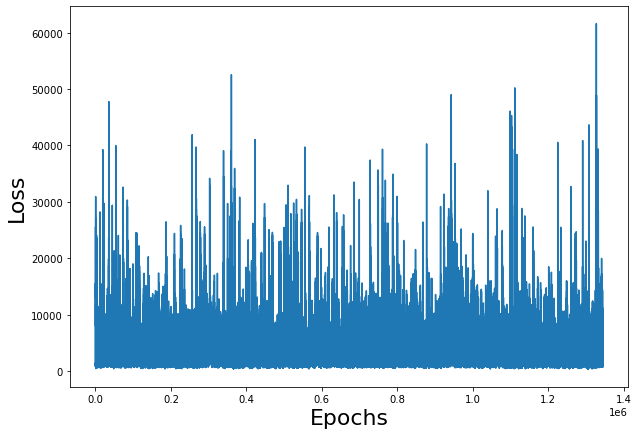

In [22]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [23]:
def test_model(model, mode='static', display=True):
    i = 0
    terminated = False
    world = WumpusWorldEnvironment()
    initialEnv, initialPercept = world.apply(4, 4, 0.2, False)        
    agent = DeepQAgent(4, 4)    
    randGen = randrange(6)
    env, agent, percept = run(initialEnv, agent, initialPercept, randGen)
    belief_state = agent.getAgentBeliefState()
    #state_, state = getState(belief_state)
    state_ = np.array([belief_state]).reshape(1,l1) + np.random.rand(1,l1)/10.0   
    state = torch.from_numpy(state_).float()
    status = 1
    reward = 0
    mov = 0
    won_counter = 0
    while terminated == False:
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            nextMove = np.random.randint(0,6)
        else:
            nextMove = np.argmax(qval_)
        env, agent, percept = run(env, agent, percept, nextMove) 
        belief_state = agent.getAgentBeliefState()
        #state_, state = getState(belief_state)
        state_ = np.array([belief_state]).reshape(1,l1) + np.random.rand(1,l1)/10.0   
        state = torch.from_numpy(state_).float()        
        reward += percept.reward        
        if reward > 0:
            won_counter += 1
            terminated = True
        if mov > 500:
            terminated = True
        if percept.isTerminated == True:
            terminated = True
        mov += 1  
        # print(percept.show())
        # print(reward, status)            
        # print(env.visualize())
    print(env.visualize())
    clear_output(wait=True)
    print("-----------------------")
    win = True if won_counter > 0 else False
    return win

In [24]:
max_games = 1000
wins = 0

for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

-----------------------
Games played: 1000, # of wins: 41
Win percentage: 4.1000000000000005%
